<a href="https://colab.research.google.com/github/mldurga/projects/blob/master/wagon_shipment_reader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wagon shipment number scanner

## Its skeleton version, further improvement is in pipeline


It is using google drive for storing the HTML file showing all the data with images and Excel file for further downstream tasks. So you need to login with the google credentials and copy paste the all the wagon images collected from the field to the folder name "wagon_images".


In [1]:
!pip install paddlepaddle paddleocr fastai -Uqq

In [2]:
from fastai.vision.all import *
from paddleocr import PaddleOCR
from PIL import Image
import re
import base64
import pandas as pd
from io import BytesIO
from IPython.display import HTML
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
path=Path('/content/drive/My Drive/')
if not (path/'wagon_images').exists():
  (path/'wagon_images').mkdir()

path="/content/drive/MyDrive/wagon_images"

Folder "wagon_images" created in your drive and please copy paste the all the images collected from the filed to further execute the commands.

In [ ]:
#Download test images if you want to test the application by unhashing and executing following 
# !wget https://user-images.githubusercontent.com/19243618/147801374-0915efba-943d-4811-866e-b00fd0a961e4.jpeg -P {path}
# !wget https://user-images.githubusercontent.com/19243618/147801504-66b17664-ef45-48e1-9f20-fc077d66676a.jpeg -P {path}
# !wget https://user-images.githubusercontent.com/19243618/147801523-1d33a350-167d-406a-a8aa-4d67d28e3f9b.jpeg -P {path}
# !wget https://user-images.githubusercontent.com/19243618/147801534-17340205-5600-4e76-9cb1-1b47c0f140b2.jpeg -P {path}
# !wget https://user-images.githubusercontent.com/19243618/147801565-c3731a50-9eda-430b-97ce-bfb2433e9b5d.jpeg -P {path}
# !wget https://user-images.githubusercontent.com/19243618/147801590-dce11c1a-d8bd-47f9-aa43-28f8ce471d4e.jpeg -P {path}
# !wget https://user-images.githubusercontent.com/19243618/147801613-1e7b6cbb-24b1-4074-a6a0-c332e40b7b6c.jpeg -P {path}
# !wget https://user-images.githubusercontent.com/19243618/147801637-921474aa-ce39-4144-afca-e8910c5d1438.jpeg -P {path}
# !wget https://user-images.githubusercontent.com/19243618/147801681-1eaf53dc-f6b4-4a46-9048-633681a5c0ed.jpeg -P {path}
# !wget https://user-images.githubusercontent.com/19243618/147801703-452cc054-98c2-40e4-9585-5b356c5ccb5f.jpeg -P {path}

In [21]:
fn=get_image_files('/content/drive/MyDrive/wagon_images')
region_names={'CR', 'KR', 'NR', 'NCR', 'NER', 'NFR', 'NWR', 'ER', 'ECR', 'ECOR',
       'SR', 'SCR', 'SCOR', 'SER', 'SECR', 'SWR', 'WR', 'WCR'}
wagon={'steel_wagon':['BFNS','BOST','BOSTHS','BOXN','BRN','BRNA','BRNAHS'],'brake_van':['BVCM','BVZC','BVZI']}

In [32]:

def wagon_num(num):
  x=[]
  for i in range(len(num)):
    if len(num[i])!=11:
      o=i
      while o<(len(num)-1):
        if len(num[i]+num[o+1])==11:
          x.append(num[i]+num[o+1])
        o+=1
    else:x.append(num[i])
  return x 

def rail_region(txts):
  region_name=[]
  if len(txts)>0:
    for x in txts:
      if x in region_names:
        region_name.append(x)
    return region_name

def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((300, 200), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

pd.set_option('display.max_colwidth', -1)


def predict():
   wagon_number=[];region=[];texts=[];nums=[];image=[]
   for i in fn:
     ocr = PaddleOCR(use_angle_cls=True, lang='en',use_gpu=False)
     result = ocr.ocr(str(i), cls=True)
     outs = [line[1][0] for line in result]
     txts=[item.upper() for sublist in [re.findall("[a-zA-Z]+",o) for o in outs] for item in sublist]
     num=[item for sublist in [re.findall(r'\d+',o) for o in outs] for item in sublist]
     r_region=rail_region(txts)
     wagon=wagon_num(num)
     wagon_number.append({wagon[0] if len(wagon)>0 else None});region.append(r_region);texts.append(txts);nums.append(num);image.append(str(i))
   df=pd.DataFrame({'wagon_number':wagon_number, 'region':region, 'texts':texts,'nums':nums,'image':image })
   df.to_excel(r'/content/drive/MyDrive/wagon_images/wagon_excel.xlsx', index=False)
   return HTML(df.to_html(formatters={'image': image_formatter}, escape=False))

Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/2.4/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/2.4/ocr/det/en/en_ppocr_mobile_v2.0_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_pgnet_valid_set='totaltext'

,wagon_number,region,texts,nums,image
0,{None},[SWR],"[SWR, BUSIHSMII]","[2115064516, 78]",
1,{None},[],"[BOSTHSM, MBS, CARRYING, TARE, ARE, FITTEDWITHTWINPIPE, GRADUATED, RELEASEAIR]","[2, 210618, 0582]",
2,{21120957227},[],"[OR, C, M]","[0748, 1, 21120957227]",
3,{80669501161},[],"[EOSM, M]","[8, 0669501161]",
4,{21151167756},None,[],"[478757, 21151167756, 2212]",
5,{86100861147},[],"[BVZI, BL, EC, R, CBO, WITH, TWIN, PIPE, R, CT, NOTTOBE, LOOSE, SHUNTE]","[3930, 86100861147, 10, 23, 24, 230]",
6,{94011810314},[],[T],"[8, 5, 94011810314]",
7,{None},[],"[BOSTISM, U, Y, A]","[30198, 2, 3]",
8,{94031710649},[],[BRN],"[229, 94031710649]",
9,{94121710580},[],[BRN],"[229, 94121710580]",

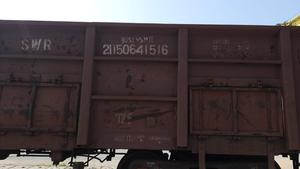
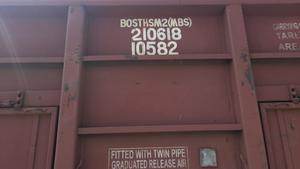
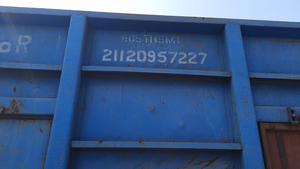
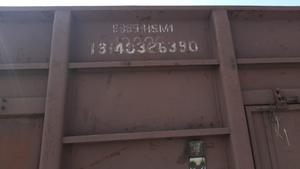
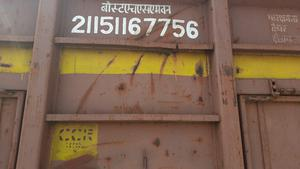
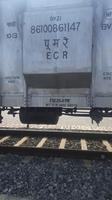
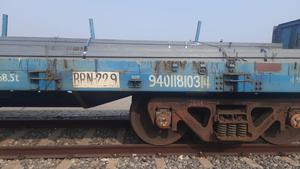
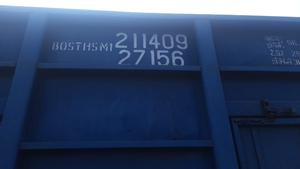
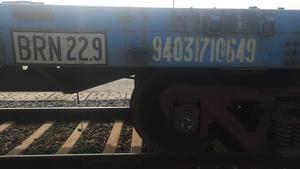
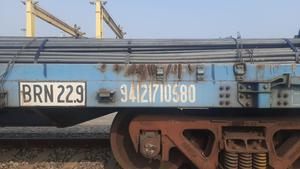

In [31]:
html_sheet=predict()
html_sheet